In [1]:
import sqlite3 as sq
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt

# 1.1 Movies Database

Take the movies dataset and turn it into a single `sqlite` database. It should have one table for each csv file in the movies dataset

In [2]:
df_movies = pd.read_csv('data/movies_metadata.csv', low_memory=False)
df_credits = pd.read_csv('data/credits.csv', low_memory=False)
df_keywords = pd.read_csv('data/keywords.csv', low_memory=False)
df_links_small = pd.read_csv('data/links_small.csv', low_memory=False)
df_ratings_small = pd.read_csv('data/ratings_small.csv', low_memory=False)


In [3]:
conn = sq.connect('data/movies.sqlite')


In [4]:
# df_movies.to_sql('movies', con = conn)
# df_credits.to_sql('credits', con = conn)
# df_keywords.to_sql('keywords', con = conn)
# df_links_small.to_sql('links_small', con = conn)
# df_ratings_small.to_sql('ratings_small', con = conn)



# 1.2 Queries

**1.2.1** Use a single query to pull the original title of movies with a budget above $5m

**1.2.2** Use a query to pull the english-language films with the word `war` in their title

**1.2.3** Left join the average ratings from the `ratings` table onto the `movies_metadata` table, so you can have a relation between budget and rating. Hint: use a subquery.

In [5]:
#1.2.1 Use a single query to pull the original title of movies with a budget above $5m
pd.read_sql("""
            SELECT original_title 
            FROM movies
            WHERE budget > 5000000;
            """, con=conn)



,original_title
0,Jumanji
1,Heat
2,Sabrina
3,GoldenEye
4,The American President
...,...
2182,The Emoji Movie
2183,Pattaya
2184,House of the Long Shadows
2185,Все и сразу


In [6]:
#1.2.2 Use a query to pull the english-language films with the word war in their title
pd.read_sql("""
SELECT *
FROM movies
WHERE (original_language == 'en') 
AND ((LOWER(original_title) LIKE '% war') 
OR (LOWER(original_title) LIKE 'war %') 
OR (LOWER(original_title) LIKE '% war %')
OR (LOWER(original_title) LIKE 'war'));
""", con = conn)


,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,335,False,None,0,"[{'id': 18, 'name': 'Drama'}]",None,19855,tt0111667,en,The War,...,1994-11-04,0.0,126.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,None,The War,0,6.3,39.0
1,551,False,None,0,"[{'id': 99, 'name': 'Documentary'}, {'id': 36,...",None,26408,tt0108515,en,The War Room,...,1993-12-05,0.0,96.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They Changed The Way Campaigns Are Won,The War Room,0,7.3,19.0
2,711,False,None,0,[],None,365371,tt0114894,en,War Stories Our Mother Never Told Us,...,None,0.0,95.0,[],Released,None,War Stories Our Mother Never Told Us,0,0.0,0.0
3,1349,False,None,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",None,26949,tt0116621,en,In Love and War,...,1996-12-18,0.0,113.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,In war they found each other...In each other t...,In Love and War,0,6.0,28.0
4,1478,False,None,0,"[{'id': 18, 'name': 'Drama'}]",None,59232,tt0118117,en,The War at Home,...,1996-11-20,0.0,119.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Rumored,There Is A Secret About To Explode.,The War at Home,0,6.9,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,42001,False,None,0,"[{'id': 99, 'name': 'Documentary'}]",None,359093,tt4875844,en,The 24 Hour War,...,2016-11-20,0.0,99.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,None,The 24 Hour War,0,7.8,4.0
120,44015,False,None,0,"[{'id': 80, 'name': 'Crime'}, {'id': 99, 'name...",http://www.wardondonfilm.com/,102935,tt1570991,en,War Don Don,...,2010-05-18,0.0,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"The war is over, a trial begins.",War Don Don,0,0.0,0.0
121,44274,False,"{'id': 173710, 'name': 'Planet of the Apes (Re...",152000000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",http://www.foxmovies.com/movies/war-for-the-pl...,281338,tt3450958,en,War for the Planet of the Apes,...,2017-07-11,369907963.0,140.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,For freedom. For family. For the planet.,War for the Planet of the Apes,0,6.7,1675.0
122,44286,False,None,0,"[{'id': 28, 'name': 'Action'}, {'id': 16, 'nam...",None,161337,tt2381375,en,Underworld: Endless War,...,2011-10-19,0.0,18.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,None,Underworld: Endless War,1,5.6,38.0


In [7]:
#1.2.3 Left join the average ratings from the ratings table onto the movies_metadata table, so you can have 
#a relation between budget and rating. Hint: use a subquery.

pd.read_sql(
"""
SELECT * 
FROM movies
JOIN (SELECT movieId, AVG(rating) as 'Average rating' 
FROM ratings_small 
GROUP BY movieId) as ratings ON ratings.movieId = movies.id
""", con = conn
)


,index,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,movieId,Average rating
0,5,False,None,60000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",None,949,tt0113277,en,Heat,...,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,0,7.7,1886.0,949,3.593750
1,9,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,...,130.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,0,6.6,1194.0,710,1.500000
2,14,False,None,98000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",None,1408,tt0112760,en,Cutthroat Island,...,119.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,The Course Has Been Set. There Is No Turning B...,Cutthroat Island,0,5.7,137.0,1408,3.616279
3,15,False,None,52000000,"[{'id': 18, 'name': 'Drama'}, {'id': 80, 'name...",None,524,tt0112641,en,Casino,...,178.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,No one stays at the top forever.,Casino,0,7.8,1343.0,524,3.555556
4,16,False,None,16500000,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",None,4584,tt0114388,en,Sense and Sensibility,...,136.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Lose your heart and come to your senses.,Sense and Sensibility,0,7.2,364.0,4584,5.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2826,45318,False,None,0,"[{'id': 18, 'name': 'Drama'}]",None,80831,tt1576459,en,Sang Pemimpi,...,121.0,"[{'iso_639_1': 'id', 'name': 'Bahasa indonesia'}]",Released,None,Sang Pemimpi,0,6.5,2.0,80831,3.250000
2827,45353,False,"{'id': 123720, 'name': 'Frankenstein (Hammer S...",0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",None,3104,tt0061683,en,Frankenstein Created Woman,...,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Now Frankenstein has created a beautiful woman...,Frankenstein Created Woman,0,5.9,33.0,3104,3.965517
2828,45403,False,None,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",None,64197,tt1047845,ru,Puteshestvie s domashnimi zhivotnymi,...,97.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,None,Travelling with Pets,0,6.0,5.0,64197,4.166667
2829,45406,False,None,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",None,98604,tt2147597,ru,Zolushka,...,91.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,None,Cinderella,0,4.6,6.0,98604,4.000000


# 2. Baseball Database

The [Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) has an sqlite version. Download it for these exercises.

**2.1** Which player has had the most homeruns?

**2.2** Is there a relation between how many homeruns a player has made in a year and his salary that year? Pull both colums together in a single query



In [8]:
conn = sq.connect('data/lahmansbaseballdb.sqlite')


In [9]:
pd.read_sql(
'''
SELECT name FROM sqlite_master WHERE type='table'
'''
,con = conn)

,name
0,allstarfull
1,appearances
2,awardsmanagers
3,awardsplayers
4,awardssharemanagers
5,awardsshareplayers
6,batting
7,battingpost
8,collegeplaying
9,divisions


In [10]:
#2.1 Which player has had the most homeruns?

#Answer: Barry Bonds is the player who had the most homeruns.

pd.read_sql(
'''
SELECT batting.playerID, nameFirst, nameLast, SUM(HR) as total_home_runs
FROM batting
JOIN (SELECT playerID, nameFirst, nameLast FROM people) as player ON player.playerID = batting.playerID
GROUP BY batting.playerID
ORDER BY total_home_runs DESC;
'''
,con = conn)



,playerID,nameFirst,nameLast,total_home_runs
0,bondsba01,Barry,Bonds,762
1,aaronha01,Hank,Aaron,755
2,ruthba01,Babe,Ruth,714
3,rodrial01,Alex,Rodriguez,696
4,mayswi01,Willie,Mays,660
...,...,...,...,...
19684,zuberbi01,Bill,Zuber,0
19685,zumayjo01,Joel,Zumaya,0
19686,zupofr01,Frank,Zupo,0
19687,zuverge01,George,Zuverink,0


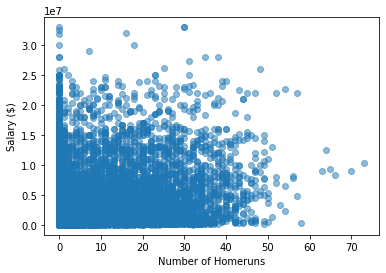

In [11]:
#2.2 Is there a relation between how many homeruns a player has made in a year and his salary that year? 
#Pull both colums together in a single query

#Answer : Since the pvalue associated with homeruns is 0, the null hypothesis can be rejected and it can be concluded
#that there is a relation between the number of homeruns and the yearly salary.

df = pd.read_sql(
'''
SELECT batting.playerId, s.yearID, batting.HR, s.salary
FROM batting
JOIN salaries s ON (s.playerID = batting.playerID) AND (s.yearID = batting.yearID)
'''
,con = conn)
df
X = df.HR
y = df.salary
plt.scatter(X,y, alpha =0.5)
plt.xlabel('Number of Homeruns')
plt.ylabel('Salary ($)')
plt.show()

In [12]:
est = sm.OLS(y, sm.add_constant(X)).fit(cov_type = 'HC2')
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     1069.
Date:                Fri, 12 Feb 2021   Prob (F-statistic):          3.90e-230
Time:                        21:23:09   Log-Likelihood:            -4.6488e+05
No. Observations:               28294   AIC:                         9.298e+05
Df Residuals:                   28292   BIC:                         9.298e+05
Df Model:                           1                                         
Covariance Type:                  HC2                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.573e+06    2.1e+04     74.793      0.000    1.53e+06    1.61e+06
HR          1.131e+05   3460.156     32.692      0.000    1.06e+05     1.2e+05
==============================================================================
Omnibus:                    17889.796   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           201577.858
Skew:                           2.949   Prob(JB):                         0.00
Kurtosis:                      14.670   Cond. No.                         11.1
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC2)
"""